In [131]:
from copy import deepcopy
from pathlib import Path
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
import tifffile
import yaml

In [45]:
%load_ext autoreload

In [46]:
%autoreload 2

In [3]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

## Specifying inputs and parameters

First, we load in the registered data we generated with [the registration and data formatting notebook](https://github.com/ding-lab/mushroom/tree/main/notebooks/tutorials/data_preperation_and_registration.ipynb#)

For more details on the schema for input data see **Formatting sections according to mushroom specifications** section [here](https://github.com/ding-lab/mushroom/tree/main/notebooks/tutorials/data_preperation_and_registration.ipynb#)
                                                                        

In [6]:
run_dir = Path('/data/estorrs/mushroom/data/runs/example_run')

In [7]:
data_config = yaml.safe_load(open(run_dir / 'registered' / 'data.yaml'))
data_config

{'resolution': 0.7267441860465117,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/runs/example_run/registered/section0_visium.h5ad'}],
   'position': 0,
   'sid': 'section0_visium'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/runs/example_run/registered/section1_xenium.h5ad'}],
   'position': 5,
   'sid': 'section1_xenium'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/runs/example_run/registered/section2_xenium.h5ad'}],
   'position': 10,
   'sid': 'section2_xenium'}],
 'target_sid': 'section0_visium'}

**Training mushroom with a single section**

A quick asside, if you want to train mushroom on a single 2D section (i.e. not a 3D dataset) you can. Just include only one section in the data config.

For example, you could do something like the below:

In [ ]:
# data_config = {
#     'resolution': XXX # whatever the resolution of the data is
#     'target_sid': 'sectionX' # whatever the section ID is
#     'sections': [
#         {
#             'sid': 'sectionX',
#             'position': 0,
#             'data': [
#                 {
#                     'dtype': XXX, # whatever the data type is
#                     'filepath': 'path/to/section/data'
#                 }
#             ]
#         }
#     ]
# }

This is the default mushroom training configuration

In [10]:
mushroom_config = deepcopy(DEFAULT_CONFIG)
mushroom_config

{'sections': None,
 'dtype_to_chkpt': None,
 'dtype_specific_params': {'visium': {'trainer_kwargs': {'tiling_method': 'radius'}}},
 'sae_kwargs': {'size': 8,
  'patch_size': 1,
  'encoder_dim': 128,
  'codebook_dim': 64,
  'num_clusters': (8, 4, 2),
  'dtype_to_decoder_dims': {'multiplex': (256, 128, 64),
   'he': (256, 128, 10),
   'visium': (256, 512, 2048),
   'xenium': (256, 256, 256),
   'cosmx': (256, 512, 1024),
   'points': (256, 512, 1024)},
  'recon_scaler': 1.0,
  'neigh_scaler': 0.01},
 'trainer_kwargs': {'input_resolution': 1.0,
  'target_resolution': 0.02,
  'pct_expression': 0.05,
  'log_base': 2.718281828459045,
  'tiling_method': 'grid',
  'tiling_radius': 1.0,
  'batch_size': 128,
  'num_workers': 0,
  'devices': 1,
  'accelerator': 'cpu',
  'max_epochs': 1,
  'steps_per_epoch': 1000,
  'lr': 0.0001,
  'out_dir': './outputs',
  'save_every': 1,
  'log_every_n_steps': 10,
  'logger_type': 'tensorboard',
  'logger_project': 'portobello',
  'channel_mapping': {},
  'data

More documentation coming soon on all the knobs you can turn with mushroom.

But for now, the most important parameters you will need to know about are the following:
+ sections - sections to train mushroom on
+ trainer_kwargs.input_resolution - resolution (in microns per pixel) of registered input sections
+ trainer_kwargs.target_resolution - resolution (in microns per pixel) of mushroom neighborhoods
+ trainer_kwargs.out_dir - directory to save mushroom outputs
+ trainer_kwargs.accelerator - whether to use "cpu" or "gpu" when training. cpu by default.
+ trainer_kwargs.steps_per_epoch - how many steps to train mushroom, 1000 is usually a good starting point, but you can sometimes get away with ~250-500 steps if faster training time is desired.
+ sae_kwargs.neigh_scaler - attempts to enforce consistency in neighborhoods between sections. Useful if data is particularly batch effecty. By default is turned off (=0.0). If you would like to use, .01 is usually a good starting point.

+ dtype_specific_params - keys are data type identifiers and values are additional configs. Values in the config will override the global values for the specific data type. For example, if you need a particular data type to be a different target resolution than the other data types you can do that here. See below cell for example

In [ ]:
target_res = 50 # mushroom will identify neighborhoods at resolution of 50 microns per pixel

mushroom_config = utils.recursive_update(mushroom_config, {
    'sections': data_config['sections'], # add input sections
    'trainer_kwargs': {
        'input_resolution': data_config['resolution'], # specify input resolution
        'target_resolution': target_res, # specify target neighborhood resolution
        'out_dir': run_dir / f'mushroom_{target_res}res', # where to save mushroom outputs
        'accelerator': 'gpu', # whether to use gpu or cpu, is set to cpu by default. since we have access to GPUs on this machine, we set to gpu for faster training.
        'steps_per_epoch': 1000, # how long to train mushroom, 1000 is usually a good starting point, but you can sometimes get away with ~250-500 steps if faster training time is desired.
    },
    'sae_kwargs': {
        'neigh_scaler': 0.0 # sometimes adding a neighborhood scaler can help neighborhood consistency across sections, If using, keep values low around .01
    }
})

mushroom_config['dtype_specific_params'] = utils.recursive_update(mushroom_config['dtype_specific_params'], {
    'visium': {
        'trainer_kwargs': {
            'target_resolution': 100  # lower resolution for visium because of distance between spots
        }
    },
})

mushroom_config

## training mushroom

initialize mushroom with config

In [17]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:loading spore for visium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting visium processing
INFO:root:using 14648 channels
INFO:root:2 sections detected: ['section0_visium', 'section0_visium_dup']
INFO:root:processing sections


ppm 0.7267441860465117 target_ppm 100
tiling size 137


INFO:root:generating image data for section section0_visium
INFO:root:generating image data for section section0_visium_dup


visium torch.Size([14648, 158, 143])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('section0_visium', 'visium'), ('section0_visium_dup', 'visium')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpbg_zx22f
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpbg_zx22f/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for xenium
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 313 channels
INFO:root:2 sections detected: ['section1_xenium', 'section2_xenium']
INFO:root:processing sections
INFO:root:generating image data for section section1_xenium


68 grid (100346, 313)
(100346, 2)
[16471 18066]


INFO:root:generating image data for section section2_xenium


68 grid (69886, 313)
(69886, 2)
[12749 17446]
xenium torch.Size([313, 318, 287])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('section1_xenium', 'xenium'), ('section2_xenium', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train mushroom

In [18]:
mushroom.train()

INFO:root:starting training for visium
Missing logger folder: /data/estorrs/mushroom/data/runs/example_run/mushroom_50res/visium_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 38.0 M
------------------------------
38.0 M    Trainable params
0         Non-trainable params
38.0 M    Total params
152.014   Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training visium, saved chkpt to /data/estorrs/mushroom/data/runs/example_run/mushroom_50res/visium_chkpts/last.ckpt
INFO:root:starting training for xenium
Missing logger folder: /data/estorrs/mushroom/data/runs/example_run/mushroom_50res/xenium_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.738    Total estimated model params size (MB)


Training: |                                                                                                   …

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



run inference to generate neighborhoods for sections

In [19]:
mushroom.embed_sections()

INFO:root:embedding visium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

We now have a trained mushroom model

## visualization of neighborhoods

We can view data type specific neighborhoods.

In [21]:
mushroom.dtypes

['visium', 'xenium']

By default, the last (most specific) level of the nieghborhood hierarchy is shown

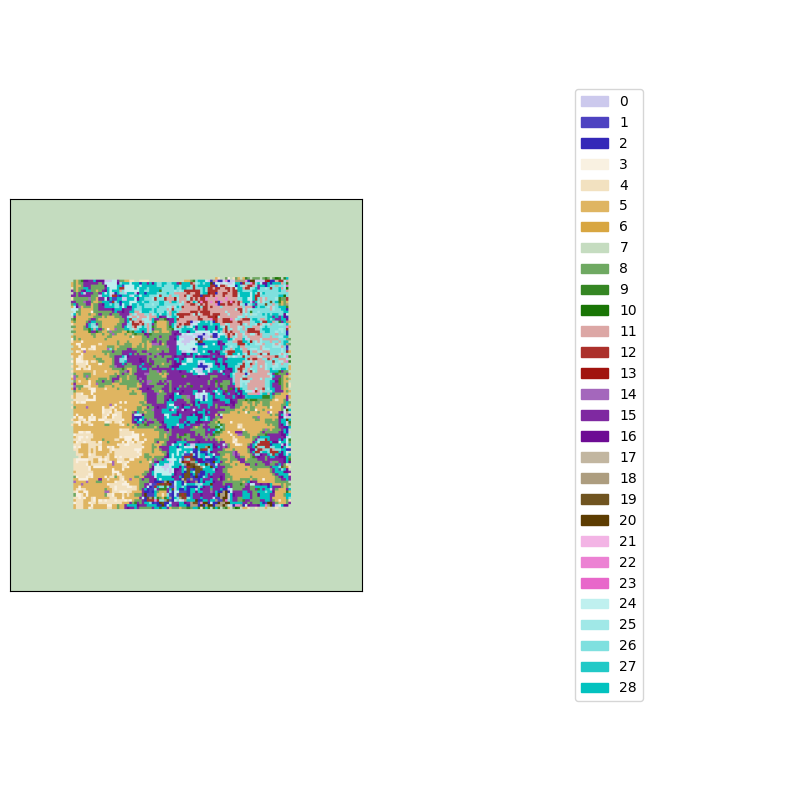

In [23]:
mushroom.display_clusters('visium', figsize=(10, 10))

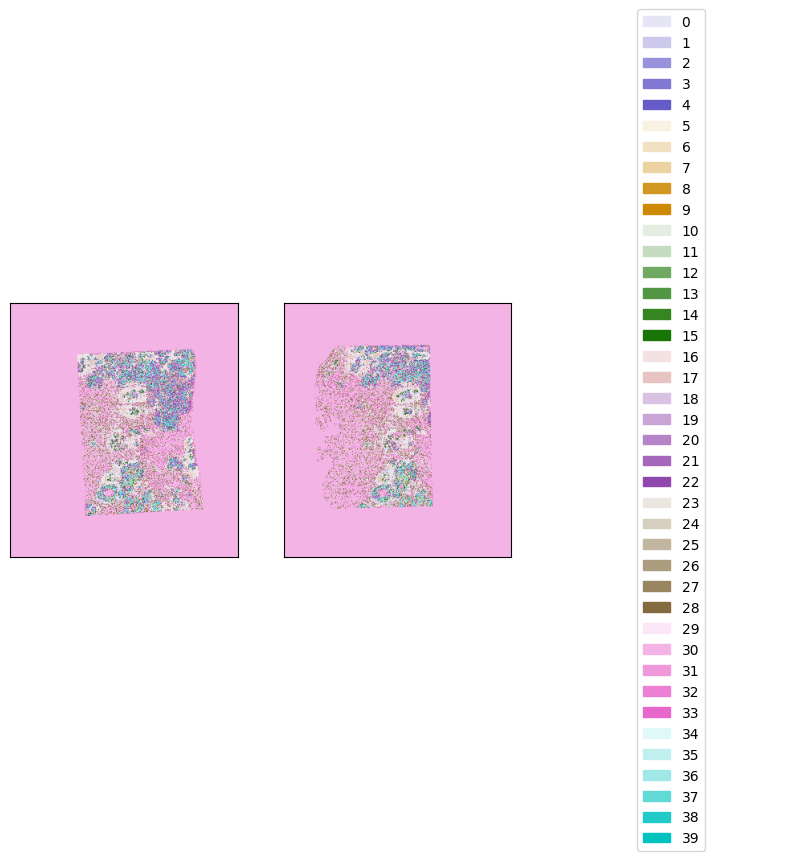

In [25]:
mushroom.display_clusters('xenium', figsize=(10, 5))

We can change the colormap. Any qualitative/discrete colormap from [matplotlib](https://matplotlib.org/stable/users/explain/colors/colormaps.html) is valid. (Make sure your colormap has enough values or an error will be thrown)

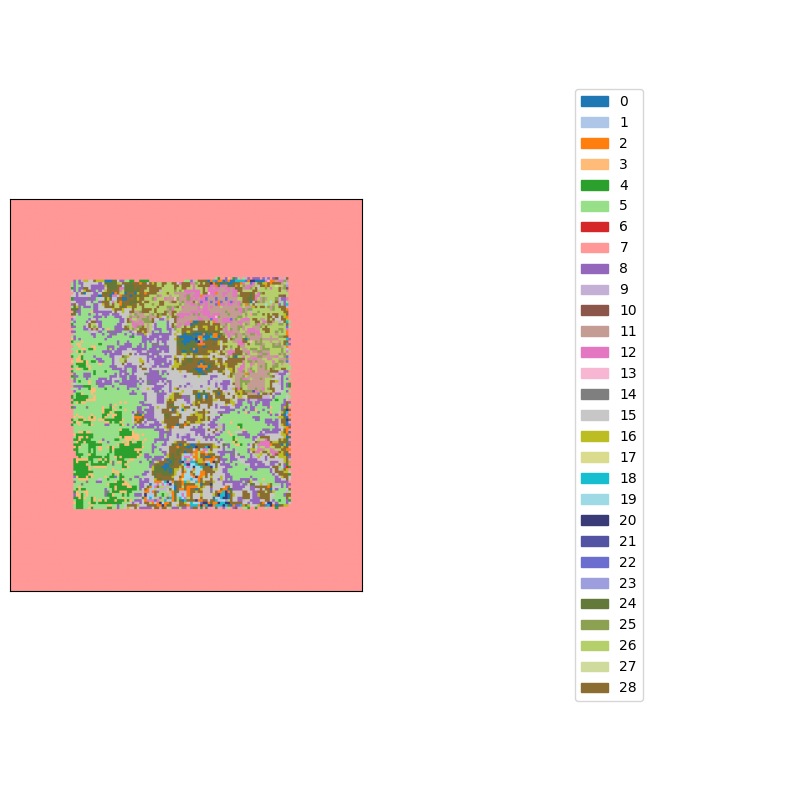

In [30]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
mushroom.display_clusters('visium', figsize=(10, 10), cmap=cmap, use_hierarchy=False) # by default hierarchy is used, so we need to set to false if displaying different cmap

We can view specific sections (useful if there are a large number of serial sections in experiment)

We can view by section ID

In [32]:
mushroom.section_ids

[('section0_visium', 'visium'),
 ('section1_xenium', 'xenium'),
 ('section2_xenium', 'xenium')]

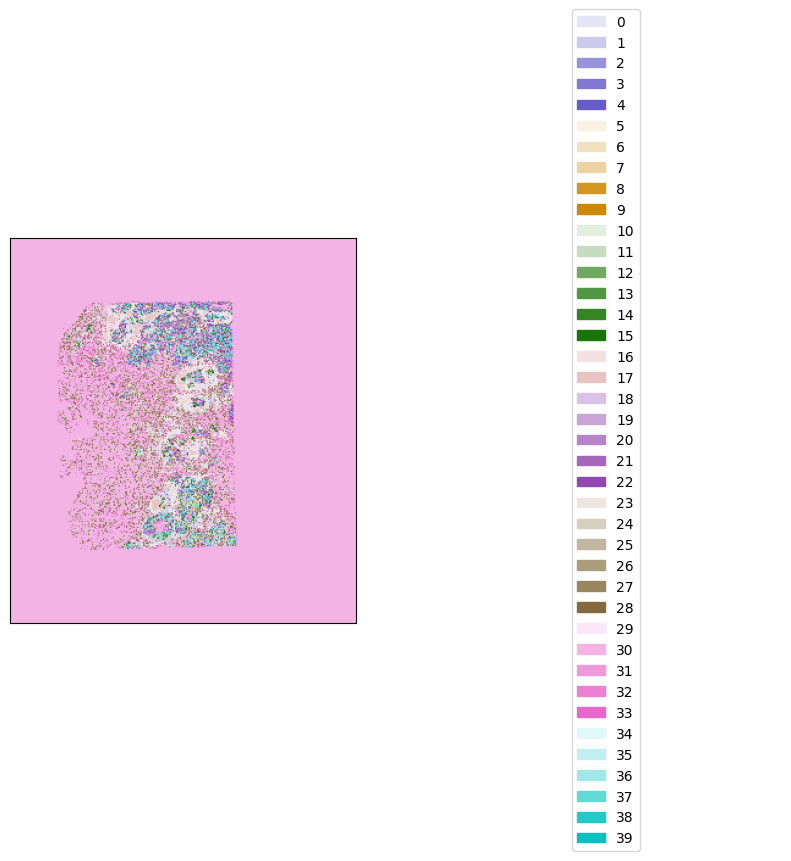

In [39]:
mushroom.display_clusters('xenium', section_ids=[('section1_xenium', 'xenium')], figsize=(10, 5))

Or by section index. Index is relative to data type, not overall sections. For example, in this case if we view the section at index 1 that would be section2_xenium, not section1_xenium, as it is the second xenium section.

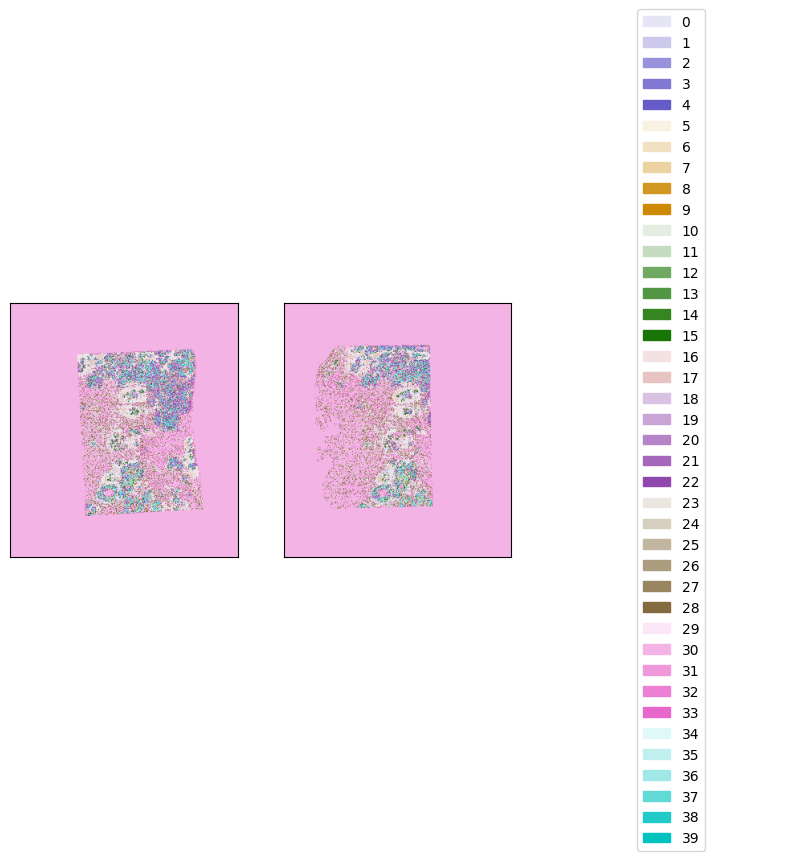

In [40]:
mushroom.display_clusters('xenium', section_idxs=[0, 1], figsize=(10, 5))

We can also view different levels of the neighborhood heirarchy

In [47]:
mushroom.num_levels

3

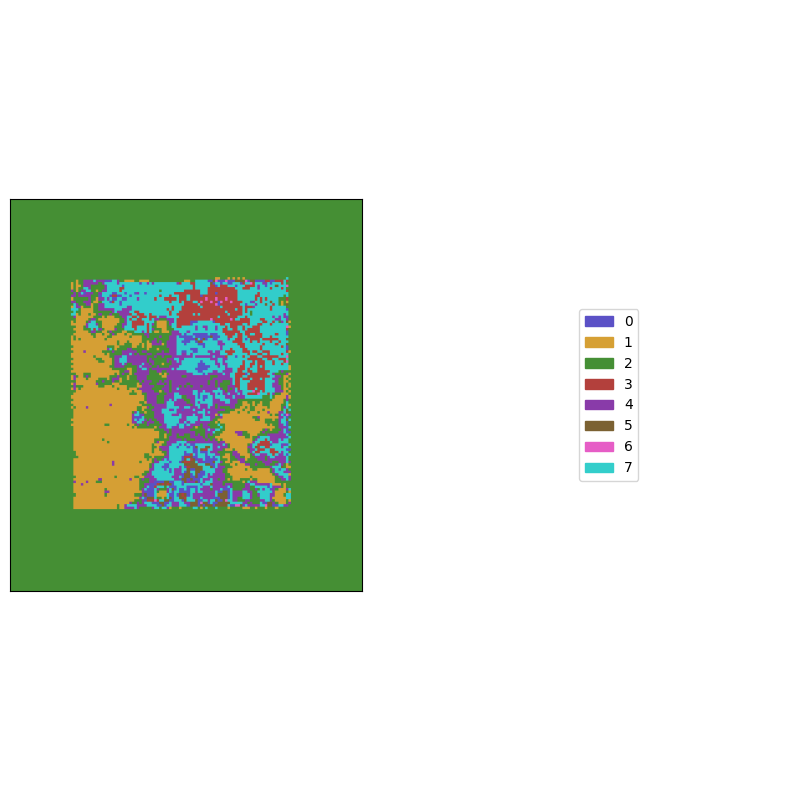

In [50]:
mushroom.display_clusters('visium', level=0, figsize=(10, 10)) # first level

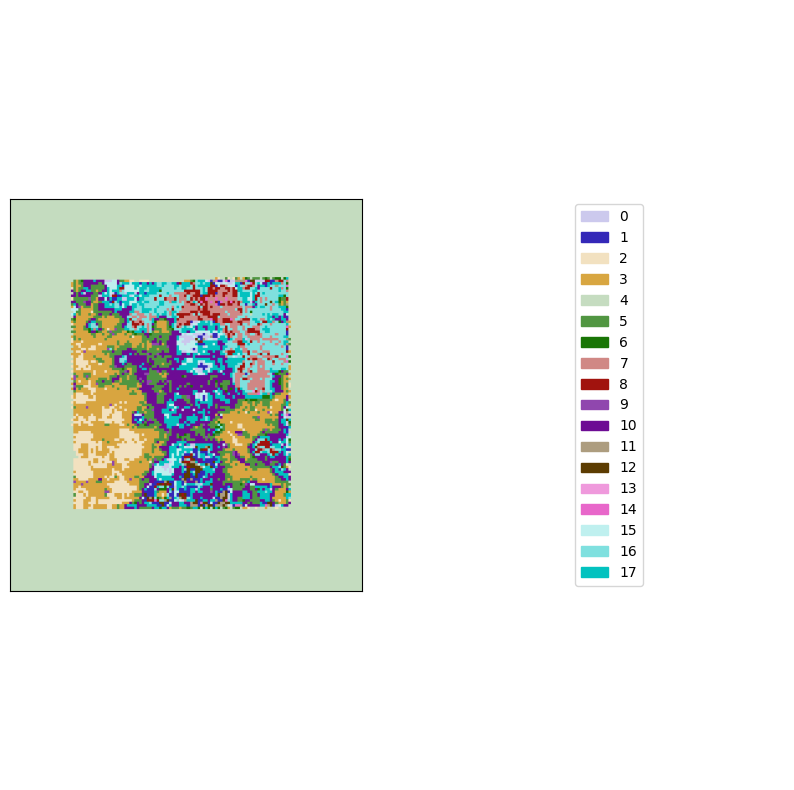

In [51]:
mushroom.display_clusters('visium', level=1, figsize=(10, 10)) # second level

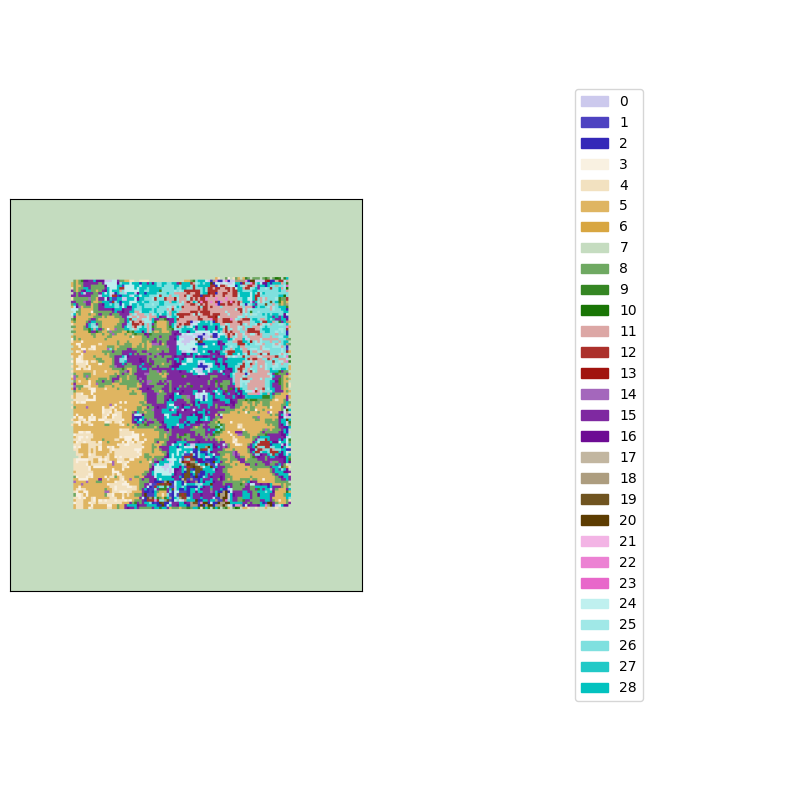

In [52]:
mushroom.display_clusters('visium', level=2, figsize=(10, 10)) # third level

We can also view the neighborhood probablilities

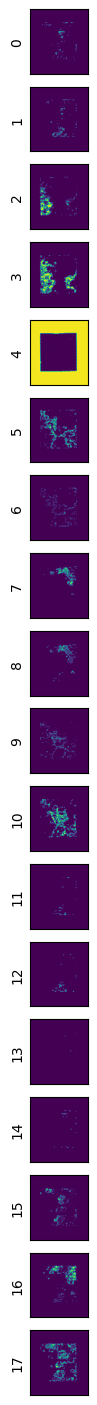

In [54]:
mushroom.display_cluster_probs('visium', level=1)

## Inspecting the mushroom object

There are a few main attributes that are useful to know about

#### Spores

A "spore" is a data type specific model. The mushroom object is effectively a wrapper for a group of spores. We can access each spore by data type.

In [55]:
mushroom.dtype_to_spore.keys()

dict_keys(['visium', 'xenium'])

In [63]:
spore = mushroom.dtype_to_spore['xenium']

[('section1_xenium', 'xenium'), ('section2_xenium', 'xenium')]

You can see section ids and order

In [66]:
spore.section_ids

[('section1_xenium', 'xenium'), ('section2_xenium', 'xenium')]

You can access neighborhoods in the .cluster attribute. It is a list of length num_levels (i.e. number of neighborhood hierarchy levels).

Each entry in the list is a numpy integer array of shape (num_sections, height, width) that holds the neighborhood labels for each neighborhood level for that data type

In [60]:
len(spore.clusters)

3

In [61]:
nbhds = spore.clusters[0] # the first neighborhood hierarchy level
nbhds.shape # (num_sections, height, width), sections have same order as .section_ids

(2, 316, 284)

In [65]:
for level in range(mushroom.num_levels):
    print(level, spore.clusters[level].shape, spore.clusters[level].max())

0 (2, 316, 284) 7
1 (2, 316, 284) 22
2 (2, 316, 284) 39


## Neighborhood statistics

We can use mushroom to derive certain statistics about the discovered neighborhoods.

here we get data type-specific neighborhood expression.

Each data frame is num_neighborhoods X num_channels. Each cell is the average expression/intensity for that neighborhood/channel. The expression values are z-scaled.

In [78]:
dtype_to_df = mushroom.calculate_cluster_intensities()
for key, df in dtype_to_df.items():
    print(key, df.shape)

visium (29, 14648)
xenium (40, 313)


In [79]:
dtype_to_df['xenium']

,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,ADIPOQ,AGR3,AHSP,AIF1,...,TUBB2B,TYROBP,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
0,-0.146752,1.662063,1.521013,0.822420,2.628739,1.540591,0.412512,0.021353,0.166189,2.515417,...,0.303069,1.612945,0.219456,0.450310,1.578716,1.601735,1.637179,2.039121,2.752545,0.640579
1,0.285561,2.345153,1.836542,1.495084,1.826851,1.953259,0.767049,0.293592,0.210339,2.348363,...,0.710602,1.576150,0.238816,0.917020,1.593264,1.960880,1.665000,2.655232,2.753170,1.089187
2,0.778383,1.955448,1.699610,1.578307,1.217659,1.249522,0.497323,0.567916,0.172868,1.686611,...,0.963560,1.089995,0.212185,1.184710,1.585592,1.423013,1.498458,1.888416,1.931971,1.297262
3,0.981253,1.779002,1.843809,1.677019,1.354298,1.204065,0.534050,0.794681,0.173731,1.624783,...,1.090328,1.021310,0.184040,1.376679,1.739871,1.252863,1.629592,1.564556,1.831663,1.522227
4,1.129331,2.096880,2.003783,1.895165,1.199889,1.102265,0.395855,0.866194,0.224738,1.638606,...,1.258675,1.069871,0.213060,1.528823,1.883336,1.434379,1.737471,1.852323,1.848827,1.678679
5,3.484130,2.782128,3.736787,3.752145,1.376209,0.245124,-0.091179,2.780061,0.372446,1.480564,...,3.238131,0.994917,0.327347,3.702584,3.809644,1.203425,3.185240,1.346261,1.454940,4.011742
6,3.122420,2.751810,3.605117,3.505534,1.575490,0.348990,-0.090108,2.535893,0.364947,1.642333,...,2.982423,1.090876,0.305546,3.385963,3.667882,1.313269,3.106687,1.503851,1.633223,3.743674
7,5.167146,2.746965,4.285221,4.853149,0.451127,-0.234565,-0.071560,4.088480,0.342073,0.564802,...,4.442640,0.349477,0.326399,5.136322,4.525382,0.497571,3.503005,0.401156,0.412661,5.238096
8,5.673578,3.649331,5.331443,5.722736,1.298966,0.027694,0.025447,4.777876,0.452060,1.349585,...,5.224223,0.856210,0.443235,5.834594,5.368246,1.048276,4.388073,1.059957,1.296212,6.246714
9,2.836134,2.673589,3.426525,3.279933,1.448698,0.356430,-0.143927,2.179648,0.384159,1.690187,...,2.739401,1.177663,0.367750,3.113533,3.422960,1.341945,2.939355,1.617833,1.634828,3.538009


## Creating Volumes

**A quick note on integrated volumes**

Interpolated volumes take into account all data types throughout all sections of the experiment. Because of this, if you have sections that don't line up particularly well (in terms of overlapping tissue) the results can be somewhat poor for portions of sections that aren't present throughout the whole z-stack.

For instance, in this example data we have 3 sections that only partially line up: the two xenium sections are somewhat offset and the visium section is a smaller portion of the xenium sections. Because of this, the neighborhoods look good in the middle of the sections, but may be poor on the outside of the sections.

If that is an issue for your use case, you can use the `learner_kwargs.data_mask` in the input mushroom config to provide a .tif file that will be used to mask out portions of the input during training. Or alternatively you can use a mask during downstream analysis to mask out voxels you don't want to consider.

Additionally, for runs with fewer slides (such as this one) the model doesn't have a whole lot of information to go on so usefulness of the model (in this toy example anyways) is somewhat muted for certain tasks.


Mushroom neighborhood volumes are generated with the `generate_interpolated_volumes` method.

generate_interpolated_volumes will create neighborhood *volumes*.

A neighborhood volume is a 3D array of shape (z, height, width) where each voxel has a label indicating what neighborhood that part of the volume is labeled as. ***z*** is the depth of the volume and is calculated as the distance (i.e. position field of the section configuration) between the first and last sections. That distance is then multiplied by ***z_scaler*** to scale the z-dimension of the final volume.

If you are getting too many or too few integrated clusters for your liking, try adjusting dist_thresh and/or resolution

The function takes the following parameters:
+ z_scaler - scale factor for z-dimension
+ level - which neighborhood hierarchy level to use for neighborhood integration
+ integrate - whether to generate integrated neighborhoods. Default is True, if False no integrated volume is generated

+ n_iterations - number of iterations to run Leiden clustering algorithm
+ dist_thresh - distance cutoff for cluster grouping. higher value typically results in more neighborhoods
+ resolution - cluster resolution, higher value typically results in more neighborhoods
+ dtype_to_weight - dictionary where keys are data types and values are weights. Higher weights indicate a heavier weighting towards that data type (i.e. neighborhoods will represent variation in that data type more than other data types). By default all data types are 1.

In [70]:
z_scaler = .5 # downscale z by .5
level = 2 # neighborhood hierarchy level
dtype_to_volume = mushroom.generate_interpolated_volumes(
    z_scaler=z_scaler,
    level=level
)
dtype_to_volume.keys()

INFO:root:generating volume for visium spore
INFO:root:generating volume for xenium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 384400 edges
INFO:root:10332 edges remaining after filtering
INFO:root:620 of 620 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 17 clusters


dict_keys(['visium', 'xenium', 'integrated'])

The returned dtype_to_volume dictionary contains data types mapped to neighborhood volumes. If integration was done there is also a "integrated" volume.

Each data type volume is of shape (z, height, width, num_neighborhoods) where num_neighborhoods is the number of neighorhoods for that data type at the specified level. The num_neighborhoods dimension contains neighborhood probabilities.

The integrated neighborhood volume is of shape (z, height, width) and each voxel is an integer label representing an integrated neighborhood.

In [71]:
for key, volume in dtype_to_volume.items():
    print(key, volume.shape)

visium (6, 316, 284, 29)
xenium (6, 316, 284, 40)
integrated (6, 316, 284)


In [73]:
# to get the labels for visium/xenium sections we just take the max of the neighborhood dimension
xenium_nbhd_volume = dtype_to_volume['xenium'].max(-1)
xenium_nbhd_volume.shape

(6, 316, 284)

We can now view the interpolated volumes.

***See note above about interpolated volumes with a limited # of sections.***

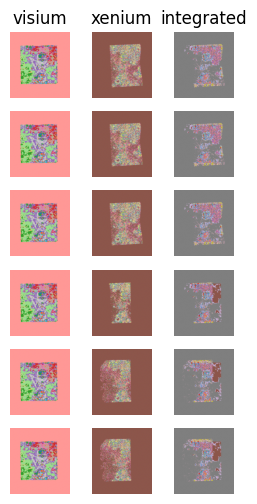

In [75]:
# y axis is the z-dimension
mushroom.display_volumes()

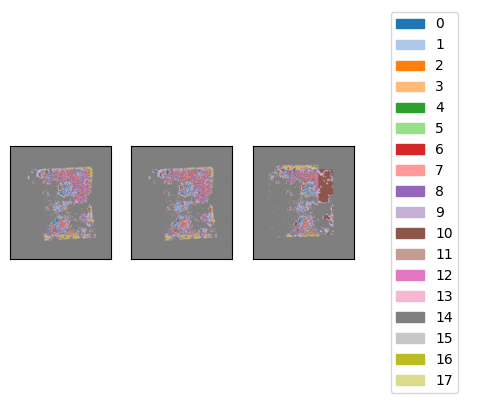

In [76]:
mushroom.display_clusters('integrated') # showing integrated clusters for the three sections

## Data type projection

Now that we have generated interpolated volumes for each data type, we can cross-project data type specific neighborhoods on to one another.

For example, here we quantify neighborhoods discovered on xenium data by all other data types

In [81]:
dtype_to_df = mushroom.calculate_cluster_intensities(projection_dtype='xenium')
dtype_to_df.keys()

dict_keys(['visium', 'xenium'])

In [82]:
# visium expression for xenium-discovered neighborhoods
dtype_to_df['visium']

,A2M,A4GALT,AAAS,AACS,AADAC,AADACL2,AADAT,AAGAB,AAK1,AAMDC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,1.341456,0.886614,1.005027,0.806125,0.211661,0.406386,0.595605,0.997416,1.099167,0.967800,...,0.905636,0.688146,0.696784,0.575979,0.582865,0.963386,0.585207,1.052356,1.318463,1.023230
1,1.287205,0.801043,1.113316,1.023265,0.292135,0.426789,0.630876,1.181447,1.182326,1.044222,...,0.975426,0.944402,0.985316,0.635466,0.698932,1.090058,0.870961,1.105159,1.308610,1.129313
2,1.798474,1.152110,1.743851,1.737239,0.434811,0.667642,0.990499,1.944977,1.830611,1.664515,...,1.550477,1.624207,1.705948,0.973344,1.156661,1.753617,1.540144,1.698853,1.884724,1.785104
3,1.143095,0.665020,1.450273,1.628617,0.459752,0.537314,0.737052,1.700231,1.471910,1.368981,...,1.303051,1.643404,1.738332,0.804426,1.066844,1.524905,1.638068,1.328370,1.260451,1.472203
4,1.490864,0.952199,1.581489,1.631955,0.432301,0.593631,0.866055,1.767956,1.655511,1.490744,...,1.421294,1.569876,1.641507,0.891629,1.083438,1.619938,1.514981,1.522485,1.589679,1.621801
5,1.362605,0.999101,1.427905,1.413580,0.337510,0.597901,0.797098,1.545569,1.499655,1.470812,...,1.396907,1.326194,1.306501,0.805753,0.985225,1.515815,1.250952,1.455895,1.449680,1.489920
6,1.084033,0.781833,1.228875,1.277730,0.314865,0.508562,0.671928,1.364501,1.267490,1.260590,...,1.186739,1.219691,1.211976,0.696418,0.868171,1.316806,1.182519,1.231269,1.185905,1.267886
7,1.299422,0.835694,1.625177,1.793396,0.476955,0.618498,0.858046,1.879470,1.667049,1.560251,...,1.491836,1.781760,1.850479,0.912366,1.175383,1.716383,1.764887,1.534620,1.451284,1.666444
8,1.593788,1.146249,1.796150,1.854997,0.468662,0.750776,0.974251,1.982941,1.854308,1.851082,...,1.765351,1.790302,1.762724,1.001869,1.277792,1.929980,1.714256,1.801203,1.724520,1.863944
9,2.192110,1.857332,1.886538,1.502322,0.336603,0.871770,1.161228,1.774408,2.090821,2.062062,...,1.975896,1.281997,1.069875,1.092978,1.207756,1.990877,1.018336,2.119794,2.212847,2.070578


we can also do this for integrated neighborhoods

In [83]:
dtype_to_df = mushroom.calculate_cluster_intensities(projection_dtype='integrated')
dtype_to_df.keys()

dict_keys(['visium', 'xenium'])

In [84]:
# visium expression for integrated neighborhoods
dtype_to_df['visium']

,A2M,A4GALT,AAAS,AACS,AADAC,AADACL2,AADAT,AAGAB,AAK1,AAMDC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,1.781424,1.175826,1.599056,1.492915,0.378222,0.623683,0.917155,1.706982,1.711338,1.534668,...,1.452668,1.368897,1.413308,0.900140,1.026281,1.596567,1.260697,1.602805,1.820954,1.645835
1,1.855700,1.313370,1.534919,1.317123,0.301853,0.641844,0.908983,1.560420,1.665547,1.553637,...,1.469777,1.153181,1.129370,0.866629,0.955344,1.546278,1.007656,1.618065,1.861463,1.600806
2,1.836251,1.154747,2.240786,2.465751,0.673063,0.837741,1.187123,2.588124,2.304938,2.120643,...,2.028567,2.450637,2.556749,1.251479,1.610835,2.344200,2.417490,2.105681,2.033482,2.295931
3,1.964057,1.404046,2.195832,2.266143,0.576301,0.912330,1.192796,2.424190,2.270921,2.250095,...,2.147892,2.187541,2.159364,1.219647,1.559432,2.351214,2.089311,2.196612,2.118741,2.279693
4,1.796827,1.118793,2.135133,2.332664,0.647114,0.778066,1.145692,2.458878,2.212948,1.982159,...,1.891665,2.303143,2.427975,1.198317,1.520362,2.208648,2.260874,1.997303,1.976828,2.194820
5,1.350059,0.951210,1.055860,0.858006,0.207629,0.442794,0.630453,1.040590,1.157476,1.063859,...,1.003137,0.731112,0.711423,0.610772,0.633936,1.049062,0.624249,1.132417,1.336729,1.099703
6,1.529916,1.109664,1.219205,0.997009,0.226443,0.518196,0.731715,1.201506,1.339676,1.248568,...,1.183768,0.851125,0.814250,0.701405,0.742607,1.228055,0.722638,1.316455,1.520576,1.280869
7,1.726508,0.990270,2.151829,2.433476,0.689332,0.745535,1.135295,2.539642,2.217021,1.928538,...,1.840849,2.433903,2.620337,1.206198,1.546470,2.208888,2.424232,1.950252,1.927648,2.192942
8,1.747222,1.015707,2.204551,2.494375,0.703002,0.773671,1.158592,2.597492,2.267129,1.993333,...,1.909579,2.500928,2.675974,1.233315,1.590754,2.274987,2.491716,2.006226,1.956733,2.247683
9,1.711259,1.130268,1.308601,1.080541,0.267673,0.523022,0.777691,1.323837,1.431444,1.253174,...,1.180500,0.929824,0.952628,0.738618,0.771115,1.257052,0.799489,1.356130,1.687439,1.337263


## Assignment of cells/barcodes/points to neighborhoods

Mushroom allows for the assignment of coordinate-based data to neighborhoods.

**Note**: The coordinates **must** be at the same resolution as the mushroom input data

For example, if you wanted to know which visium spots were in which neighborhood.

In [89]:
mushroom.section_ids

[('section0_visium', 'visium'),
 ('section1_xenium', 'xenium'),
 ('section2_xenium', 'xenium')]

In [92]:
section_id = ('section0_visium', 'visium') # section we are dealing with
level = 2 # we'll get the level 2 neighborhoods

In [95]:
fp = [entry['data'][0]['filepath']
      for entry in data_config['sections']
      if entry['sid']==section_id[0]][0]
adata = sc.read_h5ad(fp)
adata

AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial'

In [88]:
pts = adata.obsm['spatial']
pts.shape, pts

((4992, 2),
 array([[ 4131,  4636],
        [13355, 16640],
        [ 8845, 12067],
        ...,
        [10447,  6653],
        [11039, 12368],
        [ 3720, 10518]]))

In [100]:
labels = mushroom.assign_pts(
    pts, # 2D array, columns are X,Y
    section_id, # section ID points belong to
    'visium', # neighborhood identifier (i.e. which neighborhoods do you want to get)
    level=level # neighborhood hierarchy level
)
labels # neighborhood labels for the points

array([15, 15, 28, ..., 12, 15,  5])

... storing 'visium_level2' as categorical


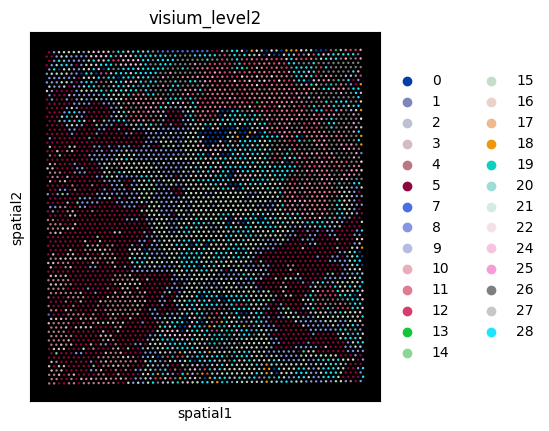

In [105]:
adata.obs['visium_level2'] = [str(x) for x in labels] # convert to str to force categorical
sc.pl.spatial(adata, color='visium_level2')

we can also get the neighborhoods for other data types / levels

... storing 'xenium_level0' as categorical


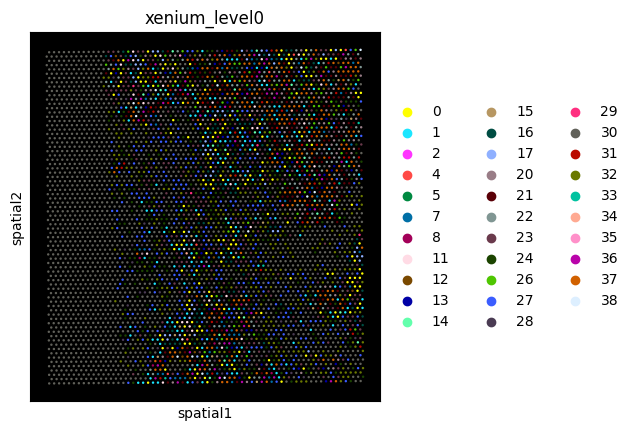

In [107]:
labels = mushroom.assign_pts(
    pts,
    section_id,
    'xenium',
    level=0,
    use_volume=True # we must use volume if doing neighborhoods other than the data type of the section in question
)
adata.obs['xenium_level0'] = [str(x) for x in labels]
sc.pl.spatial(adata, color='xenium_level0')

... storing 'integrated_level2' as categorical


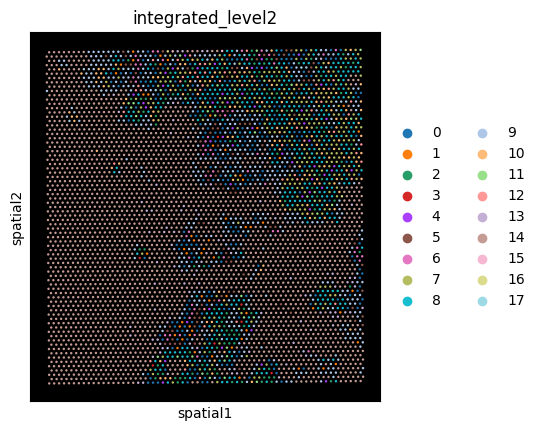

In [113]:
labels = mushroom.assign_pts(
    pts,
    section_id,
    'integrated',
    level=2,
    use_volume=True # we must use volume if doing neighborhoods other than the data type of the section in question
)
adata.obs['integrated_level2'] = [str(x) for x in labels]
sc.pl.spatial(adata, color='integrated_level2')

## Saving mushroom

We can save mushroom by running the `save` method

In [125]:
mushroom.save() # by default mushroom will save to the out_dir specified in mushroom configuration

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/runs/example_run/mushroom_50res


Mushroom saves the following files:
+ config.yaml
+ outputs.pkl

config.yaml
+ the mushroom configuration used to train the mushroom model

outputs.pkl
+ A pickle file containing the following keys
  + section_positions - positions of sections in the mushroom volume
  + section_ids - mushroom section ids
  + dtype_to_volume - data type to neighborhood volume dictionary
  + dtype_to_volume_props - data type to neighborhood volume probabilities dictionary
  + dtype_to_clusters - data type to neighborhood labels
  + dtype_to_cluster_probs - data type to neighborhood label probabilities
  + dtype_to_cluster_intensities - data type to average channel intensities for each neighborhood
  + dtype_to_cluster_to_agg - Allows for mapping of neighborhood labels to neighborhood hierarchy levels

In [129]:
config_fp = os.path.join(mushroom_config['trainer_kwargs']['out_dir'], 'config.yaml')
yaml.safe_load(open(config_fp))

{'dtype_specific_params': {'visium': {'trainer_kwargs': {'target_resolution': 100,
    'tiling_method': 'radius'}}},
 'dtype_to_chkpt': {'visium': '/data/estorrs/mushroom/data/runs/example_run/mushroom_50res/visium_chkpts/last.ckpt',
  'xenium': '/data/estorrs/mushroom/data/runs/example_run/mushroom_50res/xenium_chkpts/last.ckpt'},
 'sae_kwargs': {'codebook_dim': 64,
  'dtype_to_decoder_dims': {'cosmx': [256, 512, 1024],
   'he': [256, 128, 10],
   'multiplex': [256, 128, 64],
   'points': [256, 512, 1024],
   'visium': [256, 512, 2048],
   'xenium': [256, 256, 256]},
  'encoder_dim': 128,
  'neigh_scaler': 0.0,
  'num_clusters': [8, 4, 2],
  'patch_size': 1,
  'recon_scaler': 1.0,
  'size': 8},
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/runs/example_run/registered/section0_visium.h5ad'}],
   'position': 0,
   'sid': 'section0_visium'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/runs/example_run/registere

In [132]:
outputs_fp = os.path.join(mushroom_config['trainer_kwargs']['out_dir'], 'outputs.pkl')
outputs = pickle.load(open(outputs_fp, 'rb'))
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [133]:
outputs['section_positions'] # z index of sections for neighborhood volumes

array([0, 2, 5])

In [134]:
outputs['section_ids'] # section IDs

[('section0_visium', 'visium'),
 ('section1_xenium', 'xenium'),
 ('section2_xenium', 'xenium')]

In [138]:
# neighborhood volumes for most recent run of generate_interpolated_volumes
for dtype, volume in outputs['dtype_to_volume'].items():
    print(dtype, volume.shape)

visium (6, 316, 284)
xenium (6, 316, 284)
integrated (6, 316, 284)


In [139]:
# neighborhood probability volumes for most recent run of generate_interpolated_volumes
# with the exception of "integrated", which does not have probabilities and instead is labels
for dtype, volume in outputs['dtype_to_volume_probs'].items():
    print(dtype, volume.shape)

visium (6, 316, 284, 29)
xenium (6, 316, 284, 40)
integrated (6, 316, 284)


In [146]:
# neighborhood cluster probabilities. each value is a list of length num_levels where each item is of shape (num_sections, h, w)
for dtype, nbhds in outputs['dtype_to_clusters'].items():
    print(dtype, len(nbhds), [x.shape for x in nbhds if x is not None])

integrated 3 [(3, 316, 284)]
visium 3 [(1, 316, 284), (1, 316, 284), (1, 316, 284)]
xenium 3 [(2, 316, 284), (2, 316, 284), (2, 316, 284)]


In [147]:
# neighborhood clusters. each value is a list of length num_levels where each item is of shape (num_sections, h, w, num_nbhds)
for dtype, nbhds in outputs['dtype_to_cluster_probs'].items():
#     print(nbhds)
    print(dtype, len(nbhds), [x.shape for x in nbhds if x is not None])

visium 3 [(1, 316, 284, 8), (1, 316, 284, 18), (1, 316, 284, 29)]
xenium 3 [(2, 316, 284, 8), (2, 316, 284, 23), (2, 316, 284, 40)]


In [148]:
# neighborhood cluster probabilities, but instead of neighborhood label, it is the neighborhood hierarchy label. each value is a list of length num_levels where each item is of shape (num_sections, h, w, ...) where ... are the number of discoverable neighborhoods in each level of the neighborhood hierarchy
for dtype, nbhds in outputs['dtype_to_cluster_probs_all'].items():
#     print(nbhds)
    print(dtype, len(nbhds), [x.shape for x in nbhds if x is not None])

visium 3 [(1, 316, 284, 8), (1, 316, 284, 8, 4), (1, 316, 284, 8, 4, 2)]
xenium 3 [(2, 316, 284, 8), (2, 316, 284, 8, 4), (2, 316, 284, 8, 4, 2)]


In [169]:
# neighborhood average channel intensities

# data type specific
print('dtype specific')
for i, mapping in enumerate(outputs['dtype_to_cluster_intensities']['dtype_specific']):
    print('level ', i)
    for k, df in mapping.items():
        print(k, df.shape, df.columns[:5])
        
# integrated
print('\nintegrated')
for i, mapping in enumerate(outputs['dtype_to_cluster_intensities']['integrated']):
    if mapping is not None:
        print('level ', i)
        for k, df in mapping.items():
            print(k, df.shape, df.columns[:5])
        
print('\ncross dtype')
# cross data type
for projection_dtype, objs in outputs['dtype_to_cluster_intensities']['dtype_projections'].items():
    for level, mapping in enumerate(objs):
        if mapping is not None:
            print('projection dtype ', projection_dtype)
            for k, df in mapping.items():
                print(k, df.shape, df.columns[:5])


dtype specific
level  0
visium (8, 14648) Index(['A2M', 'A4GALT', 'AAAS', 'AACS', 'AADAC'], dtype='object')
xenium (8, 313) Index(['ABCC11', 'ACTA2', 'ACTG2', 'ADAM9', 'ADGRE5'], dtype='object')
level  1
visium (18, 14648) Index(['A2M', 'A4GALT', 'AAAS', 'AACS', 'AADAC'], dtype='object')
xenium (23, 313) Index(['ABCC11', 'ACTA2', 'ACTG2', 'ADAM9', 'ADGRE5'], dtype='object')
level  2
visium (29, 14648) Index(['A2M', 'A4GALT', 'AAAS', 'AACS', 'AADAC'], dtype='object')
xenium (40, 313) Index(['ABCC11', 'ACTA2', 'ACTG2', 'ADAM9', 'ADGRE5'], dtype='object')

integrated
level  2
visium (18, 14648) Index(['A2M', 'A4GALT', 'AAAS', 'AACS', 'AADAC'], dtype='object')
xenium (18, 313) Index(['ABCC11', 'ACTA2', 'ACTG2', 'ADAM9', 'ADGRE5'], dtype='object')

cross dtype
projection dtype  visium
visium (29, 14648) Index(['A2M', 'A4GALT', 'AAAS', 'AACS', 'AADAC'], dtype='object')
xenium (29, 313) Index(['ABCC11', 'ACTA2', 'ACTG2', 'ADAM9', 'ADGRE5'], dtype='object')
projection dtype  xenium
visium (40,

In [170]:
# maps each neighborhood label to the neighborhood hierarchy
outputs['dtype_to_cluster_to_agg']

{'visium': [{0: (0,),
   1: (1,),
   2: (2,),
   3: (3,),
   4: (4,),
   5: (5,),
   6: (6,),
   7: (7,)},
  {0: (0, 0),
   1: (0, 3),
   2: (1, 0),
   3: (1, 2),
   4: (2, 0),
   5: (2, 2),
   6: (2, 3),
   7: (3, 1),
   8: (3, 3),
   9: (4, 2),
   10: (4, 3),
   11: (5, 1),
   12: (5, 3),
   13: (6, 1),
   14: (6, 2),
   15: (7, 0),
   16: (7, 1),
   17: (7, 3)},
  {0: (0, 0, 1),
   1: (0, 3, 0),
   2: (0, 3, 1),
   3: (1, 0, 0),
   4: (1, 0, 1),
   5: (1, 2, 0),
   6: (1, 2, 1),
   7: (2, 0, 1),
   8: (2, 2, 0),
   9: (2, 3, 0),
   10: (2, 3, 1),
   11: (3, 1, 0),
   12: (3, 3, 0),
   13: (3, 3, 1),
   14: (4, 2, 0),
   15: (4, 3, 0),
   16: (4, 3, 1),
   17: (5, 1, 0),
   18: (5, 1, 1),
   19: (5, 3, 0),
   20: (5, 3, 1),
   21: (6, 1, 0),
   22: (6, 2, 0),
   23: (6, 2, 1),
   24: (7, 0, 1),
   25: (7, 1, 0),
   26: (7, 1, 1),
   27: (7, 3, 0),
   28: (7, 3, 1)}],
 'xenium': [{0: (0,),
   1: (1,),
   2: (2,),
   3: (3,),
   4: (4,),
   5: (5,),
   6: (6,),
   7: (7,)},
  {0: (0, 0

## Loading a saved mushroom object

We can load a saved mushroom object by just providing the mushroom directory.

For example, we could load a saved mushroom run like so:

In [172]:
mushroom_config['trainer_kwargs']['out_dir']

'/data/estorrs/mushroom/data/runs/example_run/mushroom_50res'

In [173]:
foo = Mushroom.from_config(mushroom_config['trainer_kwargs']['out_dir'])

INFO:root:loading spore for visium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting visium processing
INFO:root:using 14648 channels
INFO:root:2 sections detected: ['section0_visium', 'section0_visium_dup']
INFO:root:processing sections


ppm 0.7267441860465117 target_ppm 100
tiling size 137


INFO:root:generating image data for section section0_visium
INFO:root:generating image data for section section0_visium_dup


visium torch.Size([14648, 158, 143])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('section0_visium', 'visium'), ('section0_visium_dup', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/runs/example_run/mushroom_50res/visium_chkpts/last.ckpt
INFO:root:loading spore for xenium
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 313 channels
INFO:root:2 sections detected: ['section1_xenium', 'section2_xenium']
INFO:root:processing sections
INFO:root:generating image data for section section1_xenium


68 grid (100346, 313)
(100346, 2)
[16471 18066]


INFO:root:generating image data for section section2_xenium


68 grid (69886, 313)
(69886, 2)
[12749 17446]
xenium torch.Size([313, 318, 287])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('section1_xenium', 'xenium'), ('section2_xenium', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/runs/example_run/mushroom_50res/xenium_chkpts/last.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding visium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

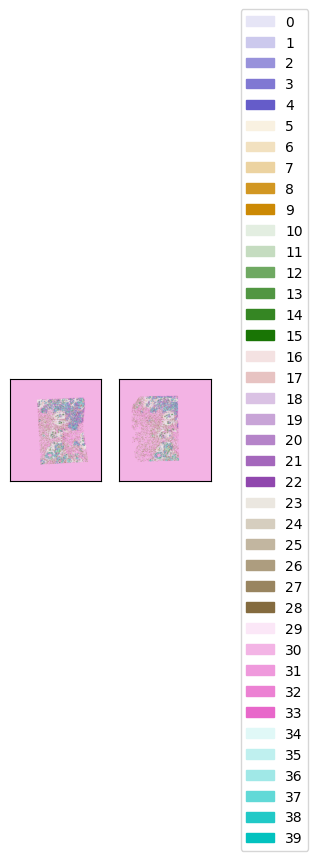

In [174]:
foo.display_clusters('xenium')